# noaa-weather-hourly
This script cleans and formats a manually downloaded National Oceanic and Atmospheric Administration (NOAA) Local Climatological Data (LCD) CSV weather file.  

This is the jupyter notebook development version of the script.  This script is converted to a .py file in the final published version.

 __Originated From:__
https://github.com/emskiphoto/Process-historical-NOAA-LCD-weather<BR>
    
Copyright Matt Chmielewski<BR>
https://github.com/emskiphoto/noaa-weather-hourly<BR>
January 6, 2025

### Load Python packages

In [1]:
# direct the jupyter notebook development script to add package path to PYTHONPATH
# to allow for loading of source modules.
import sys
sys.path.append('../noaa-weather-hourly')

In [2]:
# import modules specific to this package 
from config import *
from utils import *

In [3]:
import pandas as pd
import csv
import pathlib
import re
# turn off Jedi autocomplete (that was causing more problems than benefits post Win10 update 3-13-2020)
%config Completer.use_jedi = False 

### Parameters - Store in config.py

In [4]:
# turn on development mode to enable visualizations and other intermittent
# quality checks that aren't avaiable in the final version
is_development = True
# is_development = False

### Command Line Arguments
Which arguments can be provided in the command line?

In [5]:
filename, freqstr

('', 'H')

In [6]:
freqstr = '30T'

## Locations

In [7]:
dir_cwd = pathlib.Path.cwd()
dir_cwd

WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev')

In [8]:
# using 'data' within 'dev' folder - potentially different from 'data' in package folder
# dir_data should be dir_cwd in production script
if is_development:
    dir_data = dir_cwd / 'data'
else:
    dir_data = dir_cwd
assert dir_data.is_dir()

#### Are there any .CSV files of any naming format?
If not, stop the script, there is nothing to do without the local .csv's.

In [9]:
# pretty name of directory
dir_data_posix = dir_data.as_posix()
# list of all .csv files in dir_data
dir_data_csv_files = sorted([f_.name for f_ in dir_data.glob('*.csv') if f_.is_file()])

In [10]:
# if 'filename' was provided, work with that .csv.
# if 'filename' was not provided, review available .csv's.
# if some .csv files are present, continue.  
# Otherwise halt process and inform user.
if filename == '':
    try:
        assert len(dir_data_csv_files) >= 1
    except:
        message_ = message_no_csv_files_found.format(
            dir_data_posix = dir_data_posix)
        print(message_)
    #     assert
        raise
# elif filename != '':
    
# string version of list of all csv files
dir_data_csv_files_str = ', '.join(dir_data_csv_files)

### Locate LCD .CSV file(s) 'files_lcd_input'
This script is intended to be executed from a terminal command line.  The LCD input file(s) are expected to be saved in the same directory that the command line is executed in.  The file name(s) are expected to match the pattern associated with multiple LCD file versions in 'patterns_lcd_input_files' (two versions currently).  However, if a file(s) with this pattern is not identifed, do NOT attempt to use any non-matching .CSV file in the same directory.  Inform user that no matching file was found and no files will be opened or created.

The benefits of this approach are:
1. code will not mistakenly use non-LCD files
2. User can be sloppy (or organized) with their LCD file storage.  New source files and output files can simply be accumulated in the same folder with no data loss.
3. Simple command line requires no mandatory input, only optional frequency and parameter setting inputs.

### which version of LCD files are avaialble and which are the most recent?
1. find all files that match v1 or v2 naming
2. find the most recent file
3. Determine if most recent file is v1 or v2 format 'lcd_version'
4. see if there is more than one file with the same station ID
5. create list 'files_lcd' with one or more lcd files of same station id 

In [11]:
# 1. find all files that match v1 or v2 naming and sort by last modified date descending
# create 'version_files' dictionary with LCD version number as key and list of matching 
# files as values
version_files = {v_ : find_files_re_pattern_sorted_last_modified(dir_data, pattern_) for
                 v_, pattern_ in version_pattern_lcd_input.items()}
version_files

{1: [WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/3876540.csv'),
  WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/3875753.csv')],
 2: []}

In [12]:
# what if no files were found?  
# return message and halt process
# which files matched lcd patterns, regardless of version or date?
# files_pattern_match = [x for xs in version_files.values() for x in xs]
files_pattern_match = [x for xs in version_files.values() for x in xs]
try:
    assert len(files_pattern_match) >= 1
except:
    message_ = message_no_lcd_files_found.format(dir_data_posix = dir_data_posix,
                                 patterns_lcd_examples_str = patterns_lcd_examples_str,
                                dir_data_csv_files_str = dir_data_csv_files_str)
    print(message_)
#     assert
    raise

In [13]:
# find most recently modified file by lcd version
version_file_last_modified = {version_ : files_[0] if len(files_) > 0 else
                              None for version_, files_ in version_files.items()}
version_file_last_modified

{1: WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/data/3876540.csv'),
 2: None}

In [14]:
# 2. find the most recent file
file_last_modified = sorted([(f, f.stat().st_mtime) for
                  f in version_file_last_modified.values() if f != None],
           key=lambda x: x[1], reverse=True)[0][0]
# 3. Determine if most recent file is v1 or v2 format 'lcd_version'
# versions start with '1' so need to add 1 to zero-indexed list
lcd_version = list(version_file_last_modified.values())\
                            .index(file_last_modified) + 1
# file_last_modified, lcd_version

In [15]:
# make sure we have the right version
assert file_last_modified in version_files[lcd_version]

### Group LCD .CSV input file(s) as 'files_lcd_input'

In [16]:
# 4. see if there is more than one file that has the same station ID
# as found in 'file_last_modified'
# This requires extraction of a unique identifier in LCD file name that is common to
# other LCD files for same location (but probably different dates).  

# Note that only the LCD v2 files need to be grouped.  LCD v1 files are 
# delivered with multi-year date ranges (if requested) while LCD v2
# files are for discrete calendar years (or less), for example 'LCD_USW00014939_2020.csv'.  

# Grouping LCD v1 files could be implemented, but this would require cooperation
# from the user in terms of renaming the LCD v1 files in a specific format.
# LCD v1 files are delivered with the same name ('3876540.csv') regardless
# of date range of data in file.    

In [17]:
# files_lcd_input - empty list to hold final, qualified selection of LCD input files
files_lcd_input = []
# different treatment for v2 LCD files
if lcd_version == 2:
# extract id_file_lcd2 as the blob of characters between first and second '_'
# reference 'LCD_USW00014939_2023.csv'
    id_file_lcd2 = file_last_modified.name.split('_')[1]
#     which files contain id for the current lcd_version?
    files_ = [file_ for file_ in version_files[lcd_version] if id_file_lcd2 in file_.name]
    files_lcd_input.extend(files_)
#     print('v2')
else:
    files_lcd_input.append(file_last_modified)

In [18]:
# string version of filenames from files_lcd_input as vertical list
files_lcd_input_names_str = "\n".join([f_.name for f_ in files_lcd_input])
# files_lcd_input_names_str

#### Which columns are present by file in files_lcd_input?

In [19]:
# read only headers of each file in files_lcd_input
files_columns = {}
for file_ in files_lcd_input:
    try:
#         this is 30x faster than pd.read_csv(file_, index_col=0, nrows=0).columns.tolist()
        with open(file_, 'r') as infile:
            reader = csv.DictReader(infile)
            fieldnames = reader.fieldnames
        files_columns[file_] = sorted(fieldnames)
    except:
        continue

### Create files_usecols containing validated files
and columns to be used
_validation for each file:_
* is their a 'DATE' column?
* is at least one of the `cols_data` columns available?
* keep only columns found in `cols_noaa_processed`

#### Is 'DATE' available for every file in files_lcd_input?

In [20]:
# keep only files that have a 'DATE' column - otherwise where is this data supposed to go?
files_usecols = {file_ : cols_ for file_, cols_ in files_columns.items()
                 if 'DATE' in cols_}

#### Keep only files that have at least one cols_data column

In [21]:
files_usecols = {file_ : cols_ for file_, cols_ in files_usecols.items()
                 if len(set(cols_).intersection(set(cols_data))) >=1}

In [22]:
# reduce files_usecols to only columns used in this process
files_usecols = {file_ : sorted(set(cols_noaa_processed).intersection(set(cols_))) for
                 file_, cols_ in files_usecols.items()}

### Create df from files_usecols

In [23]:
df = pd.concat((pd.read_csv(f_, usecols=cols_, parse_dates=['DATE'],
                            index_col='DATE', low_memory=False) for
                f_, cols_ in files_usecols.items()), axis=0)\
                .reset_index().drop_duplicates()
df = df.set_index('DATE', drop=True).sort_index()
df

,STATION,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,Sunrise,Sunset
DATE,,,,,,,,,,,,,,,
2020-01-01 00:00:00,72530094846,NaN,21,25,NaN,NaN,85.0,29.10,9.94,24.0,270,NaN,8.0,NaN,NaN
2020-01-01 00:51:00,72530094846,29.80,20,24,0.00,NaN,84.0,29.08,10.00,23.0,270,NaN,8.0,NaN,NaN
2020-01-01 01:51:00,72530094846,29.80,19,23,0.00,NaN,85.0,29.08,10.00,22.0,260,NaN,6.0,NaN,NaN
2020-01-01 02:51:00,72530094846,29.81,19,22,0.00,-0.01,89.0,29.09,10.00,21.0,220,NaN,5.0,NaN,NaN
2020-01-01 03:51:00,72530094846,29.80,19,21,0.00,NaN,92.0,29.08,10.00,20.0,230,NaN,6.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 20:51:00,72530094846,30.08,27,33,T,-0.06,78.0,NaN,10.00,NaN,320,24.0,16.0,NaN,NaN
2023-12-31 21:00:00,72530094846,NaN,27,33,NaN,-0.06,78.0,29.37,9.94,31.0,320,NaN,16.0,NaN,NaN
2023-12-31 21:51:00,72530094846,30.09,27,33,NaN,NaN,78.0,NaN,10.00,NaN,330,22.0,13.0,NaN,NaN


In [24]:
# identify columns expected to be numeric & force numeric conversion 
cols_numeric_stats = df.columns.difference(cols_sunrise_sunset + cols_date_station)
for col_ in cols_numeric_stats:
# for col_ in df.columns:
    df[col_] = pd.to_numeric(df[col_], errors='coerce')
    try:
        df[col_] = df[col_].astype(float)
    except:
        pass

In [25]:
# keep track of the count of raw timestamps prior to processing
n_records_raw = df.shape[0]
# track statistics by column prior to processing, omit 'Sunrise' & 'Sunset' from stats
cols_sunrise_sunset = df.columns.intersection(['Sunrise', 'Sunset']).tolist()
df_stats_pre = df.loc[:, df.columns.difference(cols_sunrise_sunset + cols_date_station)].describe()

In [26]:
# df = df[cols_use].copy()
df.shape

(51667, 15)

In [27]:
df.head()

,STATION,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,Sunrise,Sunset
DATE,,,,,,,,,,,,,,,
2020-01-01 00:00:00,72530094846,NaN,21.0,25.0,NaN,NaN,85.0,29.10,9.94,24.0,270.0,NaN,8.0,NaN,NaN
2020-01-01 00:51:00,72530094846,29.80,20.0,24.0,0.0,NaN,84.0,29.08,10.00,23.0,270.0,NaN,8.0,NaN,NaN
2020-01-01 01:51:00,72530094846,29.80,19.0,23.0,0.0,NaN,85.0,29.08,10.00,22.0,260.0,NaN,6.0,NaN,NaN
2020-01-01 02:51:00,72530094846,29.81,19.0,22.0,0.0,-0.01,89.0,29.09,10.00,21.0,220.0,NaN,5.0,NaN,NaN
2020-01-01 03:51:00,72530094846,29.80,19.0,21.0,0.0,NaN,92.0,29.08,10.00,20.0,230.0,NaN,6.0,NaN,NaN


### Identify and Display Weather Station Information

In [28]:
# v1 & v2
# identify WBAN station
station_lcd = str(df['STATION'].value_counts().index[0])
station_wban = station_lcd[6:]  #important - this is index for the isd-history table
station_call = station_lcd[-4:] #needed for non-USA locations with 99999 WBAN
station_lcd, station_wban

('72530094846', '94846')

In [29]:
# remove 'STATION', 'REPORT_TYPE', 'SOURCE' columns - not needed anymore
df.drop(columns=['STATION', 'REPORT_TYPE', 'SOURCE'],
        inplace=True, errors='ignore')

#### Open 'isd-history.csv' containing Station details
This is location identification information.  source:  https://www.ncei.noaa.gov/pub/data/noaa/isd-history.txt.  Parsed by 'ISD History Station Table.py'.

In [30]:
isd_history_available = False
file_isd_history = find_latest_file(dir_data, pattern_isd_history_file)
if file_isd_history.is_file():
    isd_history_available = True

#### Create df_isd_history for Station Detail lookup

In [31]:
df_isd_history = pd.read_csv(file_isd_history, index_col='WBAN',
                     dtype={'WBAN': object}).sort_values(
                    by=['USAF', 'BEGIN'], ascending=[True, False])
df_isd_history.sample(5).sort_index()

,USAF,STATION NAME,CTRY,ST,CALL,LAT,LON,ELEV(M),BEGIN,END
WBAN,,,,,,,,,,
53970,720291,MESQUITE METROPOLITAN ARPT,US,TX,KHQZ,+32.747,-096.531,+0136.3,2006-01-01,2024-12-31
53984,722094,GRAND PRAIRIE MUNICIPAL AIRPO,US,TX,KGPM,+32.699,-097.047,+0179.5,2006-01-01,2024-12-31
99999,964650,LABUAN,MY,NaN,WBKL,+05.301,+115.250,+0030.8,1949-03-29,2024-12-31
99999,934010,OHAKEA,NZ,NaN,NZOH,-40.206,+175.388,+0050.0,1949-01-01,2022-11-29
99999,412560,SEEB INTL,MU,NaN,OOMS,+23.593,+058.284,+0014.6,1944-01-01,2024-12-31


In [32]:
df_isd_history['STATION NAME'].values

array(['BOGUS NORWAY', 'JAN MAYEN(NOR-NAVY)', 'SORSTOKKEN', ...,
       'IONIA COUNTY AIRPORT', 'DEMOPOLIS MUNICIPAL AIRPORT',
       'BRANSON WEST MUNICIPAL EMERSO'], dtype=object)

In [33]:
df_isd_history.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11611 entries, 99999 to 00451
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   USAF          11611 non-null  object
 1   STATION NAME  11609 non-null  object
 2   CTRY          11594 non-null  object
 3   ST            5442 non-null   object
 4   CALL          10661 non-null  object
 5   LAT           11583 non-null  object
 6   LON           11582 non-null  object
 7   ELEV(M)       11556 non-null  object
 8   BEGIN         11609 non-null  object
 9   END           11611 non-null  object
dtypes: object(10)
memory usage: 997.8+ KB


In [34]:
df_isd_history.loc[df_isd_history['CALL']==station_call]

,USAF,STATION NAME,CTRY,ST,CALL,LAT,LON,ELEV(M),BEGIN,END
WBAN,,,,,,,,,,


In [35]:
# is the station WBAN listed in df_isd_history?
station_details_available_wban = station_wban in df_isd_history.index

In [36]:
# is the station CALL listed in df_isd_history?
station_details_available_call = station_call in df_isd_history['CALL'].values

In [37]:
any([station_details_available_wban, station_details_available_call])

True

In [38]:
if station_details_available_wban:
    station_details = dict(df_isd_history.loc[station_wban].reset_index()\
                       .sort_values('END', ascending=False).iloc[0])
elif station_details_available_call:
    station_details = dict(df_isd_history.loc[
                        df_isd_history['CALL'] == station_call]\
                       .reset_index().sort_values('END',
                          ascending=False).iloc[0])
else:
    station_details = {col_ : 'Unknown' for col_ in df_isd_history.columns}

In [39]:
if station_details['LAT'] != 'Unknown':
     # add url to google maps search of lat, lon values to station_details
    google_maps_lat_lon_url = """https://maps.google.com/?q={lat},{long}"""
    google_maps_url = google_maps_lat_lon_url.format(lat = station_details['LAT'],
                                                    long = station_details['LON'])
    station_details['GOOGLE MAP'] = google_maps_url

# delete df_isd_history - no longer needed
del df_isd_history

In [40]:
station_details

{'WBAN': '94846',
 'USAF': '725300',
 'STATION NAME': "CHICAGO O\\'HARE INTERNATIONAL",
 'CTRY': 'US',
 'ST': 'IL',
 'CALL': 'KORD',
 'LAT': '+41.960',
 'LON': '-087.932',
 'ELEV(M)': '+0204.8',
 'BEGIN': '1946-10-01',
 'END': '2024-12-31',
 'GOOGLE MAP': 'https://maps.google.com/?q=+41.960,-087.932'}

In [41]:
#     create timestamps for consolidated table df
start_dt = df.index[0]
end_dt = df.index[-1]
start_str = start_dt.strftime('%Y-%m-%d')
end_str = end_dt.strftime('%Y-%m-%d')
start_str, end_str

('2020-01-01', '2023-12-31')

In [42]:
# identify hourly timestamps where the LCD source reported no observations
# This will be added as a boolean column later
idx_hours_no_source_data = pd.date_range(start_dt, end_dt, freq='H')\
                            .difference(df.index.round('H'))
# how many hours of the curent time range have no observations?
n_hours_no_source_data = len(idx_hours_no_source_data)
# idx_hours_no_source_data

#### Resolve duplicate datetime index values

In [43]:
# if a single timestamp appears more than once, average available values
# to return a single value and single timestamp (ignoring 
# NaN values of course)
df = df.groupby(level=0).mean()
df.shape

(51594, 14)

#### Extract Sunrise and Sunset by date in to dictionaries
to be applied to df_out towards end of script.
Drop Sunrise and Sunset columns after extraction here.
The source data provides only one unique sunrise/set value per day and
the rest of the day's values are NaN.  

V1 files placed sunrise/set values at the 23:59:00 timestamp.  Additional steps are taken to ensure v1 files assign sunrise/set times to a date (ie., Timestamp('2022-01-01 00:00:00'): Timestamp('2022-01-01 17:09:00') and NOT Timestamp('2022-01-01 23:59:00'): Timestamp('2022-01-01 17:09:00')), 

In [44]:
# # create date_sunrise/sunset dictionaries with dates as keys and 
# # timestamp values for time to be added back in to resampled df
temp_sunrise = df['Sunrise'].dropna()
temp_sunrise.index = temp_sunrise.index.floor('D')
date_sunrise = datetime_from_HHMM(temp_sunrise).to_dict()
del temp_sunrise

temp_sunset = df['Sunset'].dropna()
temp_sunset.index = temp_sunset.index.floor('D')
date_sunset = datetime_from_HHMM(temp_sunset).to_dict()
del temp_sunset

In [45]:
# drop sunrise/sunset columns as their information is now 
# contained in the date_sunrise/sunset dictionaries
df.drop(columns=cols_sunrise_sunset, inplace=True, errors='ignore')

#### are there timestamps that have a high count of null values?
In v1 LCD files the '23:59:00' timestamp is suspect and appears to only be a placeholder
for posting sunrise/sunset times.  Important that this step be done after
forward filling sunrise/sunset values. 
V2 LCD files do not seem to have the '23:59:00' timestamp issue.

In [46]:
# n_records_hourly_approx = int(df.shape[0]/(24))
# n_max_null = pct_null_timestamp_max * n_records_hourly_approx
n_max_null = int(pct_null_timestamp_max * df.shape[0])
n_max_null

25797

In [47]:
temp = df.loc[:, df.columns.difference(cols_sunrise_sunset)]
df_nan_ts = temp.groupby(temp.index.time).apply(lambda x: x.isna().sum()\
                            .gt(n_max_null)).all(axis=1)
times_nan = df_nan_ts.loc[df_nan_ts].index.tolist()
del temp
del df_nan_ts

In [48]:
# remove records for timestamps with a high percentage of Null values.
# note that the '23:59:00' timestamp is suspect and appears to only be a placeholder
# for posting sunrise/sunset times.  Important that this step be done after
# forward filling sunrise/sunset values.
filter_nan_times = pd.Series(df.index.time).isin(times_nan).values
df = df.loc[~filter_nan_times]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51594 entries, 2020-01-01 00:00:00 to 2023-12-31 23:51:00
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HourlyAltimeterSetting     44166 non-null  float64
 1   HourlyDewPointTemperature  50125 non-null  float64
 2   HourlyDryBulbTemperature   50133 non-null  float64
 3   HourlyPrecipitation        33895 non-null  float64
 4   HourlyPressureChange       17501 non-null  float64
 5   HourlyRelativeHumidity     50126 non-null  float64
 6   HourlyStationPressure      49982 non-null  float64
 7   HourlyVisibility           50093 non-null  float64
 8   HourlyWetBulbTemperature   49984 non-null  float64
 9   HourlyWindDirection        49541 non-null  float64
 10  HourlyWindGustSpeed        9991 non-null   float64
 11  HourlyWindSpeed            50137 non-null  float64
dtypes: float64(12)
memory usage: 5.1 MB


In [49]:
# test = df.between_time('23:01:00', '00:59:00').select_dtypes(include=[int, float])
# test.groupby(test.index.time).sum()

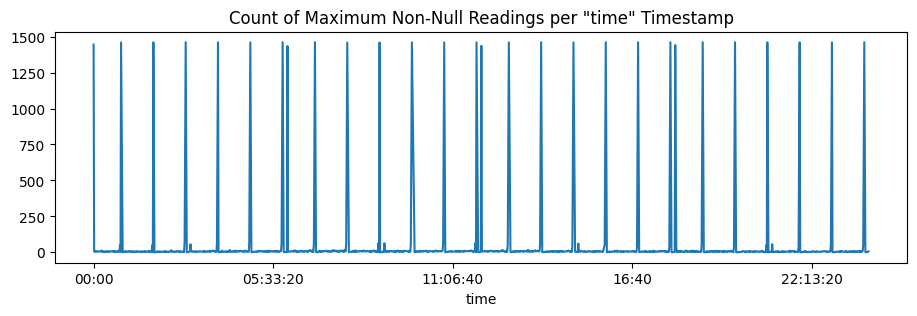

In [50]:
if is_development:
    df.groupby(df.index.time).count().max(axis=1).sort_index().plot(figsize=(11,3),
   title='Count of Maximum Non-Null Readings per "time" Timestamp')

In [51]:
# df.loc[filter_nan_times]

In [52]:
#     Check what percentage of data has null data and print to screen
df_pct_null_data = pd.DataFrame({'Percent N/A': df.isnull().sum().divide(len(df)).round(3)})
df_pct_null_data_pre_formatted = df_pct_null_data['Percent N/A']\
                            .apply(lambda n: '{:,.1%}'.format(n))
# remove 'Hourly' prefix for display only
col_rename_remove_hourly = {col_ : col_.replace('Hourly', '') for
                            col_ in df_pct_null_data_pre_formatted.index}

#### Display Station Details

In [53]:
# exclude station lifetime history dates - could cause confusion
station_details_exclude = ['BEGIN', 'END']
station_details_display = {k_ : v_ for k_, v_ in station_details.items() if
                           k_ not in station_details_exclude}

In [54]:
print('--------------------------------------------')
print('------ ISD Weather Station Properties ------')
print('--------------------------------------------')
for k_, v_ in station_details_display.items():
    print("{:<15} {:<10}".format(k_, v_))
print('\n')

--------------------------------------------
------ ISD Weather Station Properties ------
--------------------------------------------
WBAN            94846     
USAF            725300    
STATION NAME    CHICAGO O\'HARE INTERNATIONAL
CTRY            US        
ST              IL        
CALL            KORD      
LAT             +41.960   
LON             -087.932  
ELEV(M)         +0204.8   
GOOGLE MAP      https://maps.google.com/?q=+41.960,-087.932




In [55]:
# message_pct_null_data = f"""Percent Missing Values by Column for LCD source file '{file_lcd_input.name}' for USAF station {station_usaf} at '{station_details['STATION NAME']}' from {start_str} to {end_str}."""
# message_pct_null_data = """Percent Missing Values by Column for LCD source file(s):
# {files_lcd_input_names_str}\n\nFor USAF station {station_usaf} at '{station_name}'
# from {start_str} to {end_str}."""
message_pct_null_data = """Percent Missing Values by Column from {start_str} to {end_str} for LCD source file(s):\n
{files_lcd_input_names_str}"""
message_ = message_pct_null_data.format(files_lcd_input_names_str = files_lcd_input_names_str,
                            station_usaf = station_details['USAF'],
                            station_name = station_details['STATION NAME'],
                            start_str = start_str,
                            end_str = end_str)

print(message_)

Percent Missing Values by Column from 2020-01-01 to 2023-12-31 for LCD source file(s):

3876540.csv


In [56]:
print('--------------------------------------------------------------')
print('------ Percent Null Values by Column Before Processing -------')
print('--------------------------------------------------------------')
display(df_pct_null_data_pre_formatted.rename(index=col_rename_remove_hourly))

--------------------------------------------------------------
------ Percent Null Values by Column Before Processing -------
--------------------------------------------------------------


AltimeterSetting       14.4%
DewPointTemperature     2.8%
DryBulbTemperature      2.8%
Precipitation          34.3%
PressureChange         66.1%
RelativeHumidity        2.8%
StationPressure         3.1%
Visibility              2.9%
WetBulbTemperature      3.1%
WindDirection           4.0%
WindGustSpeed          80.6%
WindSpeed               2.8%
Name: Percent N/A, dtype: object

### Resample Hourly

In [57]:
%%time
dfs = {}
# individually resample each column on an hourly frequency.
# This will produce series
# with perfect, complete datetime indexes.  However, it is quite
# possible that NaN values will remain (ie. a contiguous 3-hour
# period of NaN values).  Remaining NaN values will
# be resolved through interpolation later in the script.
# this method is used because NaN values can appear at different timestamps
# in each column
# at this point the df should contain only numeric data
for col_ in df.columns:
    print(col_)
    dfs[col_] = df[col_].dropna().resample('H').mean()

HourlyAltimeterSetting
HourlyDewPointTemperature
HourlyDryBulbTemperature
HourlyPrecipitation
HourlyPressureChange
HourlyRelativeHumidity
HourlyStationPressure
HourlyVisibility
HourlyWetBulbTemperature
HourlyWindDirection
HourlyWindGustSpeed
HourlyWindSpeed
CPU times: total: 78.1 ms
Wall time: 85 ms


### Create df_out - the beginning of the final output

In [58]:
# join the resampled series from the previous step, remove any
# duplicates and ensure the index is recognized as hourly frequency.
# df_out = pd.concat(dfs, axis=1).drop_duplicates().asfreq('H')
# important to enforce dtype 'float' as 'HourlyRelativeHumidity' and 
# other columns had a 'Float64' (capital 'F') that generated
# errors in interpolation step.
df_out = pd.concat(dfs, axis=1).drop_duplicates()\
                .asfreq('H').astype(float)
del dfs
del df
df_out

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed
DATE,,,,,,,,,,,,
2020-01-01 00:00:00,29.800,20.5,24.5,0.0,NaN,84.5,29.09,9.97,23.5,270.0,NaN,8.0
2020-01-01 01:00:00,29.800,19.0,23.0,0.0,NaN,85.0,29.08,10.00,22.0,260.0,NaN,6.0
2020-01-01 02:00:00,29.810,19.0,22.0,0.0,-0.01,89.0,29.09,10.00,21.0,220.0,NaN,5.0
2020-01-01 03:00:00,29.800,19.0,21.0,0.0,NaN,92.0,29.08,10.00,20.0,230.0,NaN,6.0
2020-01-01 04:00:00,29.800,19.0,21.0,0.0,NaN,92.0,29.08,10.00,20.0,230.0,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,30.060,27.0,33.0,NaN,NaN,78.0,NaN,10.00,NaN,320.0,NaN,16.0
2023-12-31 20:00:00,30.075,27.5,33.0,NaN,-0.06,80.0,NaN,10.00,NaN,320.0,24.0,16.0
2023-12-31 21:00:00,30.090,27.0,33.0,NaN,-0.06,78.0,29.37,9.97,31.0,325.0,22.0,14.5


### Interpolate Null Values
According to the following parameters:
Because observed weather data commonly contains gaps (ie., NaN or null values), noaa-weather-hourly will attempt to fill in any such gaps to ensure that in each record a value is present for all of the hourly timestamps. To do so, it will use time-based interpolation for gaps up to a default value of 24 hours long ('max_records_to_interpolate').  For example if the dry bulb temperature has a gap with neighboring observed values like (20, X, X, X, X, 25), noaa-weather-hourly will replace the missing values to give (20, 21, 22, 23, 24, 25).

If a gap exists in the data that is larger than max_records_to_interpolate, NaN values will be left untouched and a complete datetime index will be preserved.

In [59]:
df_out = df_out.interpolate(method='time',
            limit = max_records_to_interpolate)

### Optional Frequency Resample
If the freqstr is not 'H', resample.  If the input freqstr is higher than 'H', resample and interpolate, else resample using mean.

In [60]:
# freqstr = '30T'

In [61]:
run_resample = False
resample_interpolate = False
#     what is the delta value of the input freqstr?
freqstr_delta = pd.date_range(start_dt, periods=100,
                           freq=freqstr).freq.delta
# If the freqstr is not 'H', run the resample process
if freqstr != 'H':
    run_resample = True

# If the input freqstr is higher frequency 
# than df_out, resample using interpolation
resample_interpolate = freqstr_delta < df_out.index.freq.delta

In [62]:
if run_resample:
#     resample via interpolation
    if resample_interpolate:
        df_out = df_out.resample(freqstr).interpolate()
# or resample using mean
    elif not resample_interpolate:
        df_out = df_out.resample(freqstr).mean()

In [63]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70127 entries, 2020-01-01 00:00:00 to 2023-12-31 23:00:00
Freq: 30T
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HourlyAltimeterSetting     70127 non-null  float64
 1   HourlyDewPointTemperature  70127 non-null  float64
 2   HourlyDryBulbTemperature   70127 non-null  float64
 3   HourlyPrecipitation        70127 non-null  float64
 4   HourlyPressureChange       70123 non-null  float64
 5   HourlyRelativeHumidity     70127 non-null  float64
 6   HourlyStationPressure      70127 non-null  float64
 7   HourlyVisibility           70127 non-null  float64
 8   HourlyWetBulbTemperature   70127 non-null  float64
 9   HourlyWindDirection        70127 non-null  float64
 10  HourlyWindGustSpeed        70103 non-null  float64
 11  HourlyWindSpeed            70127 non-null  float64
dtypes: float64(12)
memory usage: 7.0 MB


### Pre- Post-Processing Statistical Comparison

In [64]:
# create general statistics on post-processed dataset for
# comparison with pre-processed dataset to understand how/if 
# processing significantly altered series values
df_stats_post = df_out[df_stats_pre.columns].describe()
df_stats_post

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed
count,70127.000000,70127.000000,70127.000000,70127.000000,70123.000000,70127.000000,70127.000000,70127.000000,70127.000000,70127.000000,70103.000000,70127.000000
mean,30.008839,40.548524,53.032585,0.003819,0.000503,65.332348,29.288203,9.311386,46.873040,183.952069,22.757759,9.486546
std,0.211951,18.499351,20.005589,0.023498,0.039248,16.784390,0.207919,1.853842,17.333869,99.997244,4.139610,4.900586
min,29.080000,-17.000000,-8.000000,0.000000,-0.260000,15.000000,28.380000,0.000000,-9.000000,0.000000,16.000000,0.000000
25%,29.880000,27.000000,37.000000,0.000000,-0.020000,53.000000,29.160000,9.985000,33.500000,95.000000,20.142857,6.000000
50%,30.005000,39.500000,53.000000,0.000000,0.000000,67.000000,29.287500,10.000000,47.000000,200.000000,22.000000,9.000000
75%,30.140000,57.000000,70.000000,0.000000,0.020000,79.000000,29.410000,10.000000,63.000000,260.000000,24.070926,12.979167
max,30.810000,80.000000,100.000000,1.223333,0.240000,100.000000,30.070000,10.000000,84.000000,360.000000,68.428571,37.000000


In [65]:
df_mean_comp = pd.concat([df_stats_pre.loc['mean'].T, df_stats_post.loc['mean'].T],
                         axis=1, keys=['Source Mean', 'Processed Mean']).round(2)
df_mean_comp['% Difference'] = df_mean_comp.pct_change(axis=1).iloc[:,-1]\
                                .fillna(0).round(4)\
                                .apply(lambda n: '{:,.2%}'.format(n))
df_mean_comp.rename(index=col_rename_remove_hourly, inplace=True)
df_mean_comp

,Source Mean,Processed Mean,% Difference
AltimeterSetting,29.99,30.01,0.07%
DewPointTemperature,40.66,40.55,-0.27%
DryBulbTemperature,51.85,53.03,2.28%
Precipitation,0.01,0.00,-100.00%
PressureChange,0.00,0.00,0.00%
RelativeHumidity,68.39,65.33,-4.47%
StationPressure,29.27,29.29,0.07%
Visibility,8.78,9.31,6.04%
WetBulbTemperature,46.34,46.87,1.14%
WindDirection,183.76,183.95,0.10%


In [66]:
# TO-DO:  Overall pre- post- statistics check
df_stats_pre.sub(df_stats_post).div(df_stats_pre).mean().mean()
# df_stats_pre.pct_change(df_stats_post)
# df_stats_pre.eq(df_stats_post).sum().sum()
# df_stats_pre.size

-0.10949850423066025

In [67]:
#     Check what percentage of data has null data and print to screen
df_pct_null_data_post = pd.DataFrame({'Percent N/A': df_out.isnull()\
                              .sum().divide(len(df_out)).round(4)})
df_pct_null_data_post_formatted = df_pct_null_data_post['Percent N/A']\
                                .apply(lambda n: '{:,.2%}'.format(n))
display(df_pct_null_data_post_formatted.rename(
                index = col_rename_remove_hourly))

AltimeterSetting       0.00%
DewPointTemperature    0.00%
DryBulbTemperature     0.00%
Precipitation          0.00%
PressureChange         0.01%
RelativeHumidity       0.00%
StationPressure        0.00%
Visibility             0.00%
WetBulbTemperature     0.00%
WindDirection          0.00%
WindGustSpeed          0.03%
WindSpeed              0.00%
Name: Percent N/A, dtype: object

In [68]:
df_pct_null_comp = pd.concat([df_pct_null_data_pre_formatted, 
                             df_pct_null_data_post_formatted], 
                            axis=1).rename(index=col_rename_remove_hourly)
df_pct_null_comp

,Percent N/A,Percent N/A
AltimeterSetting,14.4%,0.00%
DewPointTemperature,2.8%,0.00%
DryBulbTemperature,2.8%,0.00%
Precipitation,34.3%,0.00%
PressureChange,66.1%,0.01%
RelativeHumidity,2.8%,0.00%
StationPressure,3.1%,0.00%
Visibility,2.9%,0.00%
WetBulbTemperature,3.1%,0.00%
WindDirection,4.0%,0.00%


In [69]:
df_mean_comp

,Source Mean,Processed Mean,% Difference
AltimeterSetting,29.99,30.01,0.07%
DewPointTemperature,40.66,40.55,-0.27%
DryBulbTemperature,51.85,53.03,2.28%
Precipitation,0.01,0.00,-100.00%
PressureChange,0.00,0.00,0.00%
RelativeHumidity,68.39,65.33,-4.47%
StationPressure,29.27,29.29,0.07%
Visibility,8.78,9.31,6.04%
WetBulbTemperature,46.34,46.87,1.14%
WindDirection,183.76,183.95,0.10%


In [70]:
df_pct_null_comp.join(df_mean_comp)

,Percent N/A,Percent N/A,Source Mean,Processed Mean,% Difference
AltimeterSetting,14.4%,0.00%,29.99,30.01,0.07%
DewPointTemperature,2.8%,0.00%,40.66,40.55,-0.27%
DryBulbTemperature,2.8%,0.00%,51.85,53.03,2.28%
Precipitation,34.3%,0.00%,0.01,0.00,-100.00%
PressureChange,66.1%,0.01%,0.00,0.00,0.00%
RelativeHumidity,2.8%,0.00%,68.39,65.33,-4.47%
StationPressure,3.1%,0.00%,29.27,29.29,0.07%
Visibility,2.9%,0.00%,8.78,9.31,6.04%
WetBulbTemperature,3.1%,0.00%,46.34,46.87,1.14%
WindDirection,4.0%,0.00%,183.76,183.95,0.10%


In [71]:
# Round df_out to 1 decimal place
df_out = df_out.round(1)

### Add Sunrise/Sunset timestamps to df_out

In [72]:
# apply date_sunrise/sunset to df_out index to create sunrise/sunset columns
for col_, dict_ in zip(cols_sunrise_sunset, [date_sunrise, date_sunset]):
    if len(dict_) > 1:
        df_out[col_] = pd.DataFrame.from_dict(dict_, orient='index')\
                    .reindex(df_out.index).ffill().astype('datetime64[s]')
    else:
        df_out[col_] = pd.NaT

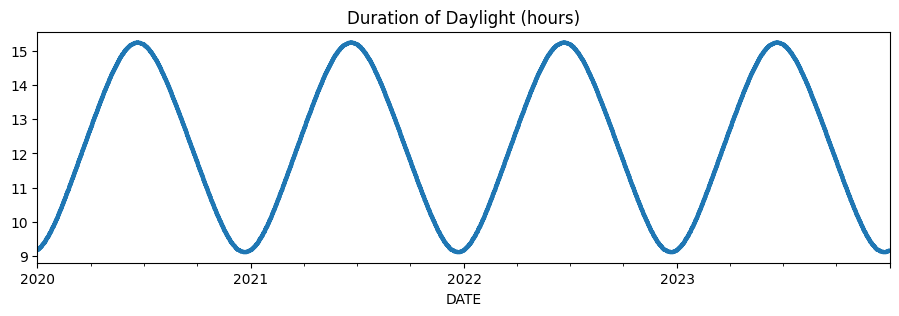

In [73]:
if is_development:
#     df_out[cols_sunrise_sunset].diff(axis=1).iloc[:,-1].dt.total_seconds().div(3600).plot()
    df_out[cols_sunrise_sunset].diff(axis=1).iloc[:,-1]\
        .dt.seconds.div(3600).plot(
        title = 'Duration of Daylight (hours)', figsize = (11,3), lw=3)

In [74]:
# add column to document hourly obervations where no source data was provided.
df_out['No source data'] = df_out.index.isin(idx_hours_no_source_data)

### Quality Control

#### No duplicate records

#### Complete and consistent timestamps

#### correct dtypes

#### Nan values only in columns permitted to have NaN

#### Rename Columns - remove 'hourly' from names

In [75]:
df_out.rename(columns=col_rename_remove_hourly, errors='ignore',
             inplace=True)

### Save Outputs to Disk
* df_out
* df_mean_comp
* df_pct_null_comp

#### TO-DO:
Consolidated processing summary report as .txt file containing df_mean_comp, df_pct_null_comp, station_details, and other statistics

#### Name export file 

In [82]:
# Save output file to current working directory (ie,
# where command line command was entered)
file_out_name = file_output_format.format(
            STATION_NAME = slugify(station_details['STATION NAME']),
            start_str = start_str,
            end_str = end_str,
            freqstr = freqstr)
file_out = dir_cwd / file_out_name
# what if file name is too long for current OS? - TO-DO
# file_out.as_posix().__len__()
file_out

WindowsPath('C:/Users/user/OneDrive/python_envs/noaa-weather-hourly-cli/dev/chicago-ohare-international 2020-01-01 to 2023-12-31 30T.csv')

#### Save df_out to csv as file_out

In [85]:
df_out.to_csv(file_out)
assert file_out.is_file()

### Cleanup

In [ ]:
del df_out

# END